In [84]:
# Import Necessary Libraries
import numpy as np
import scipy.io

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable


from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.spatial import distance as Distance

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

# NIH034 Analysis

In [15]:
######## Load in EVENTS struct to find correct events
eventsDir = '../NIH034/behavioral/paRemap/' + 'events.mat'

events = scipy.io.loadmat(eventsDir)
events = events['events']

# print number of incorrect events and which words they belonged to
incorrectIndices = events['isCorrect'] == 0
incorrectEvents = events[incorrectIndices]
incorrectWords = []
for i in range(0, len(incorrectEvents)):
    incorrectWords.append(incorrectEvents['probeWord'][i][0])


print "There were ",len(incorrectEvents), " number of incorrect events."
print "The list of incorrect probe words: \n", wordList
# 
# get only correct events
correctIndices = events['isCorrect'] == 1
events = events[correctIndices]

print "\nThis is the length of the events struct with only correct responses: ", len(events)

There were  49  number of incorrect events.
The list of incorrect probe words: 
{"[u'PANTS']": 7, "[u'JUICE']": 8, "[u'BRICK']": 12, "[u'CLOCK']": 13, "[u'GLASS']": 9}

This is the length of the events struct with only correct responses:  1431
([u'paRemap'], [u'NIH034'], [u'session_0a'], [[0]], [u'PROBEWORD_OFF'], [[0]], [[1443210025443.0]], [u'BRICK'], [u'CLOCK'], [[1]], [u'BLOCK_0'], [[array([u'MINIBLOCK_1'], 
      dtype='<U11')]], [[1443210029744.0]], [[1443210030061.0]], [[1443210024426.0]], [[1443210024942.0]], [[1739.079345703125]], [u'CLOCK'], [u'/Volumes/Shares/FRNU/data/eeg/NIH034/eeg.reref/NIH034_150925_1531'], [[424991]])


In [20]:
#### Extract wordpairs data into a dictionary for a subject/session/block
#### dictionary{wordpair:{channels}}
def extractSubjSessionBlockData(subj, session, block):
    # file directory for a subj/session/block
    filedir = '../condensed_data_' + subj + '/blocks/' + session + '/' + block
    wordpairs = os.listdir(filedir) 
    
    # initialize data dictionary with meta data
    data_dict = {}
    data_dict['meta'] = {'subject': subj,
                         'session': session,
                         'block': block}
    data_dict['data'] = {}
    for wordpair in wordpairs:    # loop thru all wordpairs
        wordpair_dir = filedir + '/' + wordpair
        all_channel_mats = os.listdir(wordpair_dir)
        
        data_dict['data'][wordpair] = {}
        for channel in all_channel_mats: # loop thru all channels
            chan_file = wordpair_dir + '/' + channel

            ## 00: load in data
            data = scipy.io.loadmat(chan_file)
            data = data['data']
            
            ## 01: get the time point for probeword on
            timeZero = data['timeZero'][0][0][0]
        
            ## 02: get the time point of vocalization
            vocalization = data['vocalization'][0][0][0]
        
            ## 03: Get Power Matrix
            power_matrix = data['powerMatZ'][0][0]
            
            chan = channel.split('_')[0]
            
            # convert channel data into a json dict
            data_dict['data'][wordpair][chan] = {'timeZero': timeZero,
                                          'timeVocalization':vocalization,
                                          'powerMat': power_matrix}
    
    print "The size of power matrices are: ", power_matrix.shape
    
    return data_dict

def isReverse(pair1, pair2):
    pair1split = pair1.split('_')
    pair2split = pair2.split('_')
    if pair1split[0] == pair2split[1] and pair1split[1] == pair2split[0]:
        return True
    else:
        return False

# Compute all pairwise distances between first_mat to second_mat
def computePairDistances(first_mat, second_mat):
    distance_list = []
    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
    distance_list = 1.0 - np.ndarray.flatten(np.array(distance_list))
    return distance_list  
    
distances = Distance.cosine # define distance metric to use
def computeWithinDistances(mat):
    distance_list = np.array(())
    
    distance_list = []
    for idx in range(0, mat.shape[0]):
        for x in mat[idx+1:,:]:
            dist = distances(x,mat[idx,:])
            to_append = np.array(dist)
            distance_list.append(to_append)
            
    distance_list = 1.0 - np.ndarray.flatten(np.array(distance_list))
    return distance_list

In [21]:
######## Get list of files (.mat) we want to work with ########
subj = 'NIH034' # change the directories if you want
filedir = '../condensed_data_' + subj + '/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:] # change which sessions we want
print "Analyzing subject: ", subj
print "The sessions: ", sessions

# loop through each session
for idx, session in enumerate(sessions):
    # the session directory
    sessiondir = filedir + sessions[idx]
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    print "The blocks are: \n", blocks, ' \n'
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # loop through each block one at a time, analyze
    for i in range(0, 1):
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # 
        print 'Subject: ', subj
        print 'Session: ', session
        print 'Block: ', block
        
        block_data = extractSubjSessionBlockData(subj, session, block)
        print block_data.keys()

        break

    break

Analyzing subject:  NIH034
The sessions:  ['session_1', 'session_2']
The blocks are: 
['BLOCK_0', 'BLOCK_1', 'BLOCK_2', 'BLOCK_3', 'BLOCK_4', 'BLOCK_5']  

Subject:  NIH034
Session:  session_1
Block:  BLOCK_0
The size of power matrices are:  (20, 7, 149)
['meta', 'data']


#### Reaction Times
Reaction times in these blocks were saved with 100 ms windows and 50 ms overlap. 

With a timeZero at 45 for all the blocks, the vocalizations can be filtered out as such:
< 1 second, 1-2 seconds and >2 seconds.

In [26]:
print "1 second is index ", 45+(1.0/(50.0/1000)) , " in the data structure we have."
print "2 seconds is index ", 45+(2.0/(50.0/1000))
print "3 seconds is index ", 45+(3.0/(50.0/1000))
print "timeZero of probeWord on is: ", 45

1 second is index  65.0  in the data structure we have.
2 seconds is index  85.0
3 seconds is index  105.0
timeZero of probeWord on is:  45


In [56]:
######## Get list of files (.mat) we want to work with ########
subj = 'NIH034'
filedir = '../condensed_data_NIH034/blocks/'
sessions = os.listdir(filedir)
sessions = sessions[2:]

session_pval_dict = {}
# loop through each session
for session in sessions:
    print "Analyzing session ", session, " WITHIN BLOCKS."
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # initialize p-value matrices to visualize heat maps of significant channels
    session_pval_diff_mat = np.array(())
    session_pval_same_mat = np.array(())
    session_pval_reverse_mat = np.array(())
    
    # loop through each block one at a time, analyze
    for i in range(0, 6):
        print "Analyzing block ", blocks[i]
        block = blocks[i]
        block_dir = sessiondir + '/' + block
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []
        
        print "These are the wordpairs in this block: ", wordpairs
        
        ################# 01: Create WordPair Groups #################
        # create same group pairs
        for idx, pair in enumerate(wordpairs):
            same_word_group.append([pair, pair])
        
        # create reverse, and different groups
        for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
            if isReverse(pairs[0], pairs[1]):
                reverse_word_group.append([pairs[0], pairs[1]])
            else:
                diff_word_group.append([pairs[0], pairs[1]])
        
        break
    print "\nGot same_word_group, reverse_word_group and diff_word_group for session: ", session
    print "\n",same_word_group
    print "\n",reverse_word_group
    print "\n",diff_word_group
    break

Analyzing session  session_1  WITHIN BLOCKS.
Analyzing block  BLOCK_0
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']

Got same_word_group, reverse_word_group and diff_word_group for session:  session_1

[['BRICK_CLOCK', 'BRICK_CLOCK'], ['CLOCK_BRICK', 'CLOCK_BRICK'], ['GLASS_JUICE', 'GLASS_JUICE'], ['JUICE_GLASS', 'JUICE_GLASS']]

[['BRICK_CLOCK', 'CLOCK_BRICK'], ['GLASS_JUICE', 'JUICE_GLASS']]

[['BRICK_CLOCK', 'GLASS_JUICE'], ['BRICK_CLOCK', 'JUICE_GLASS'], ['CLOCK_BRICK', 'GLASS_JUICE'], ['CLOCK_BRICK', 'JUICE_GLASS']]


In [82]:
print "Meta data: ", block_data['meta'] # print meta data for this dict

### FOR CERTAIN SESSION BLOCK
# loop through each wordpair
bufferblock_data = block_data
wordpairs = block_data['data'].keys()
print "Data available per channel: ", block_data['data'][wordpairs[0]]['1'].keys()

for wordpair in wordpairs:
    wordpairdata = block_data['data'][wordpair]
    for chan in wordpairdata.keys():
        timeVocalization = wordpairdata[chan]['timeVocalization']
        timeZero = wordpairdata[chan]['timeZero']
        powerMat = wordpairdata[chan]['powerMat']
        
        onesec_indices = np.where(timeVocalization <= 65)
        onetwosec_indices = np.where((timeVocalization <= 85) & (timeVocalization > 65))[0]
        twothreesec_indices = np.where((timeVocalization <= 105) & (timeVocalization > 85))[0]

        # reformat data to get the indices we want 
        block_data['data'][wordpair][chan]['timeVocalization'] = timeVocalization[onetwosec_indices]
        block_data['data'][wordpair][chan]['powerMat'] = powerMat[onetwosec_indices,:,:]
        
#         print twothreesec_indices.shape
#         print onetwosec_indices.shape
#         print timeVocalization.shape
#         print timeZero.shape
#         print powerMat.shape
#         break
    
#     break

def getDistances(same_word_group, reverse_word_group, diff_word_group, block_data, chan):
    ################# 02a: Same Words Cosine Distnace #################
    # extract channel data for same word group
    same_word_dict = {}
    same_word_distances = []
    for same_words in same_word_group:
        same_word_data = [] # array to store all the feature freq. vectors for a specific word

        # extract data to process - average across time 
        same_word_key = same_words[0]
        probeOnTime = block_data['data'][same_word_key][str(chan)]['timeZero']
        vocalizationTime = block_data['data'][same_word_key][str(chan)]['timeVocalization']
        powerMat = block_data['data'][same_word_key][str(chan)]['powerMat']

        for i in range(0, len(vocalizationTime)):
            # either go from timezero -> vocalization, or some other timewindow
            same_word_data.append(np.ndarray.flatten(np.mean(powerMat[i,:,probeOnTime:vocalizationTime[i]],axis=1)))
        same_word_data = np.array(same_word_data)
        # do a pairwise comparison of all events in this word pair
        same_word_data = computeWithinDistances(same_word_data)
        same_word_dict[same_word_key] = same_word_data

    for key in same_word_dict.keys():
        same_word_distances.append(same_word_dict[key])
    same_word_distances = np.array(same_word_distances)

    ################# 02b: Reverse Words Cosine Distnace #################
    # extract channel data for same word group
    reverse_word_dict = {}
    reverse_word_distances = []
    for reverse_words in reverse_word_group:
        reverse_word_data = {}

        for wdx, word in enumerate(reverse_words): # get the first and second word pair
            reverse_word_databuffer = []

            # extract wordKey and data from MAIN block dictinoary
            reverse_word_key = reverse_words[wdx]
            probeOnTime = block_data['data'][reverse_word_key][str(chan)]['timeZero']
            vocalizationTime = block_data['data'][reverse_word_key][str(chan)]['timeVocalization']
            powerMat = block_data['data'][reverse_word_key][str(chan)]['powerMat']

            # average across time and append a frequency feature vector for every event in this group
            for i in range(0, len(vocalizationTime)):
                # either go from timezero -> vocalization, or some other timewindow
                reverse_word_databuffer.append(np.ndarray.flatten(np.mean(powerMat[i,:,probeOnTime:vocalizationTime[i]],axis=1)))
            reverse_word_data[str(wdx)] = np.array(reverse_word_databuffer)

        # do a pairwise comparison of all events in this word pair
        reverse_word_dict['vs'.join(reverse_words)] = computePairDistances(reverse_word_data['0'], reverse_word_data['1'])

    for key in reverse_word_dict.keys():
        reverse_word_distances.append(reverse_word_dict[key])
    reverse_word_distances = np.array(reverse_word_distances)

    ################# 02c: Different Words Cosine Distnace #################
    # extract channel data for same word group
    diff_word_dict = {}
    diff_word_distances = []
    for diff_words in diff_word_group:
        diff_word_data = {}

        # extract data to process - average across time 
        for wdx, word in enumerate(diff_words): # get the first and second word pair
            diff_word_databuffer = []

            # extract wordKey and data from MAIN block dictinoary
            diff_word_key = diff_words[wdx]
            probeOnTime = block_data['data'][diff_word_key][str(chan)]['timeZero']
            vocalizationTime = block_data['data'][diff_word_key][str(chan)]['timeVocalization']
            powerMat = block_data['data'][diff_word_key][str(chan)]['powerMat']

            # average across time and append a frequency feature vector for every event in this group
            for i in range(0, len(vocalizationTime)):
                # either go from timezero -> vocalization, or some other timewindow
                diff_word_databuffer.append(np.ndarray.flatten(np.mean(powerMat[i,:,probeOnTime:vocalizationTime[i]],axis=1)))
            diff_word_data[str(wdx)] = np.array(diff_word_databuffer)

        # do a pairwise comparison of all events in this word pair
        diff_word_dict['vs'.join(diff_words)] = computePairDistances(diff_word_data['0'], diff_word_data['1'])
    # put all word distances into 1 list
    for key in diff_word_dict.keys():
        diff_word_distances.append(diff_word_dict[key])
    diff_word_distances = np.array(diff_word_distances)
    
#     print same_word_dict.keys()
#     print reverse_word_dict.keys()
#     print diff_word_dict.keys()
    
    return same_word_distances, reverse_word_distances, diff_word_distances

def flattenArrayDistances(word_distances):
    buff_distances = np.array(())
    for i in range(0, len(word_distances)):
        buff_distances = np.append(buff_distances, word_distances[i], axis=0)
    return buff_distances

Meta data:  {'session': 'session_1', 'block': 'BLOCK_0', 'subject': 'NIH034'}
Data available per channel:  ['powerMat', 'timeZero', 'timeVocalization']


(561,)
(595,)
(1190,)


/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:78: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:108: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


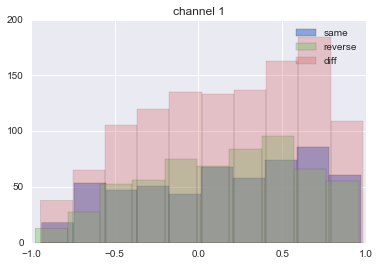

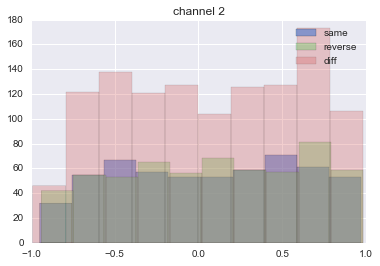

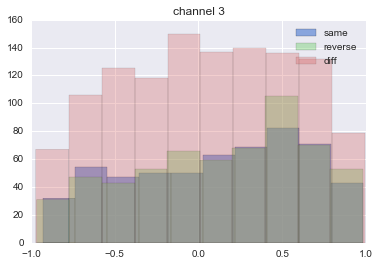

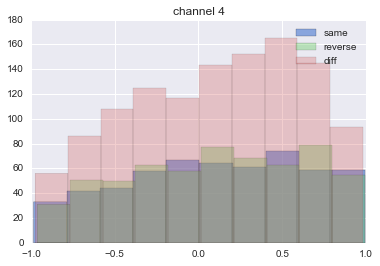

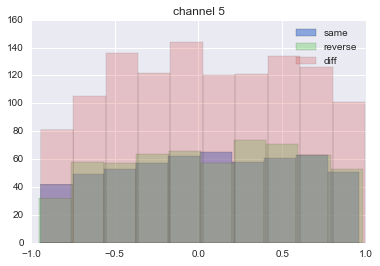

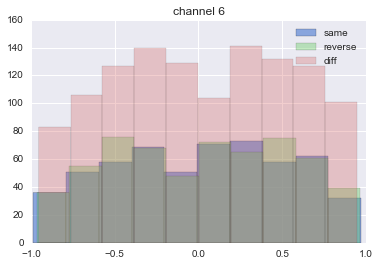

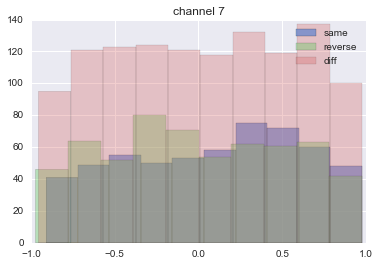

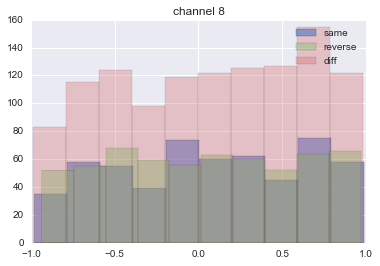

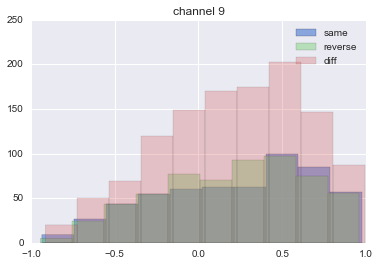

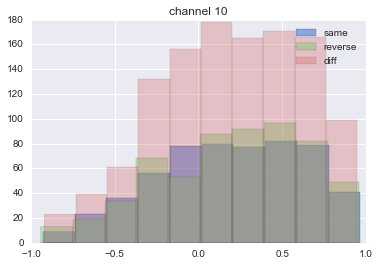

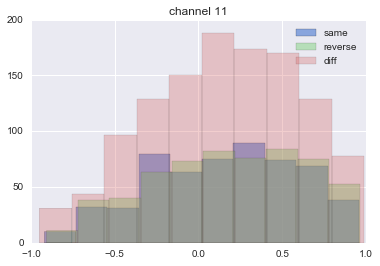

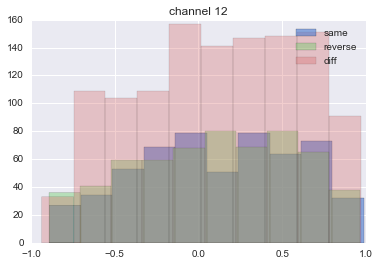

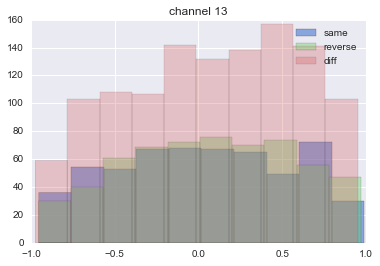

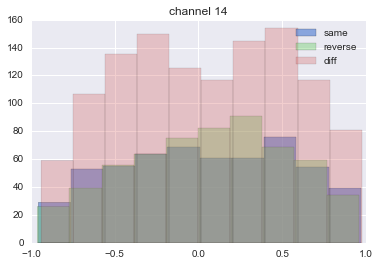

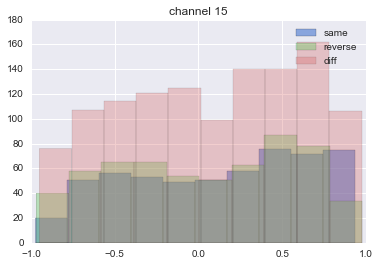

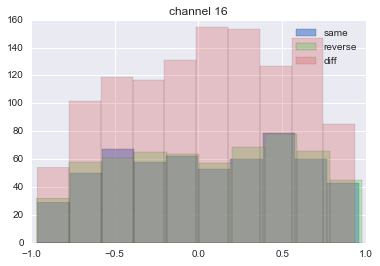

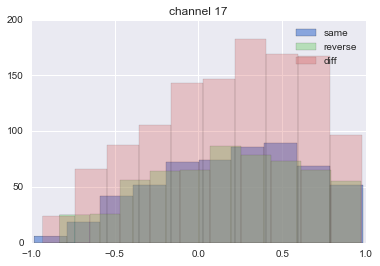

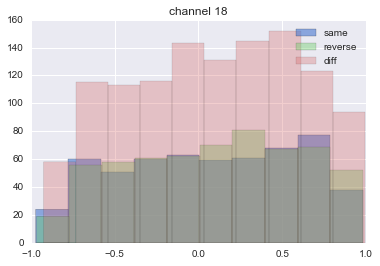

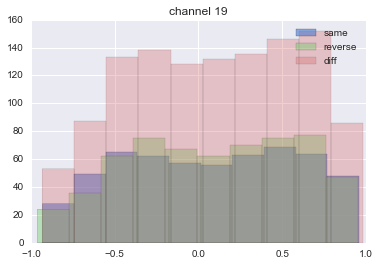

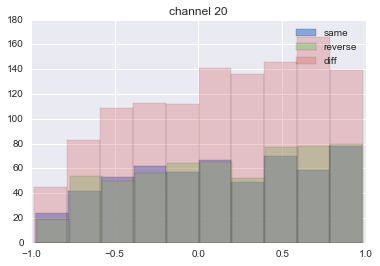

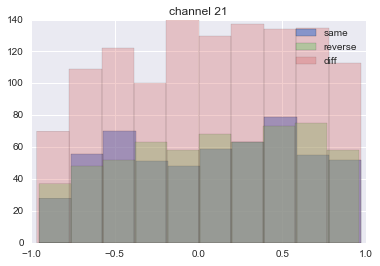

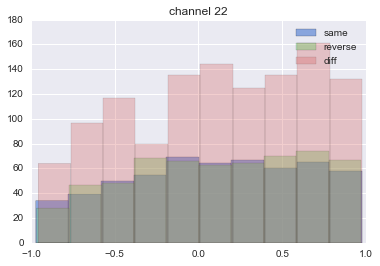

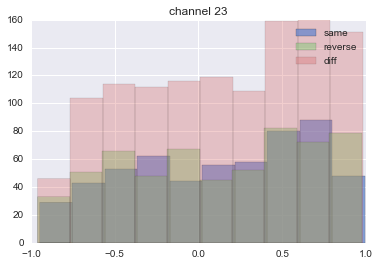

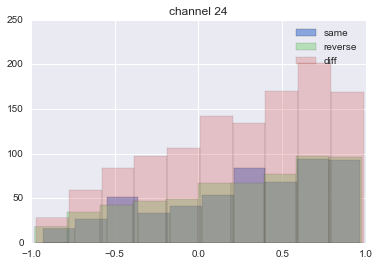

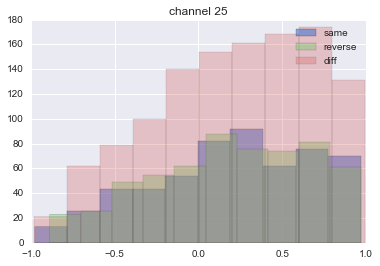

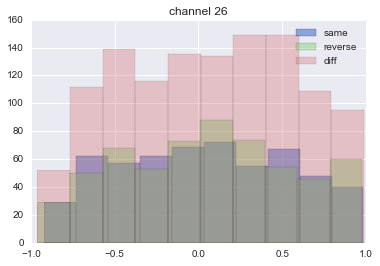

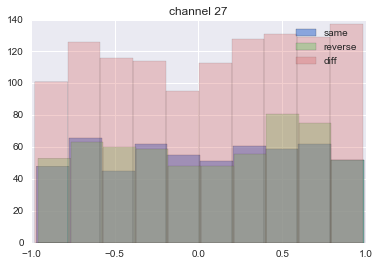

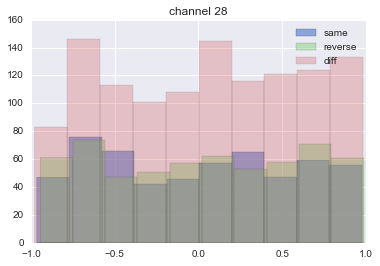

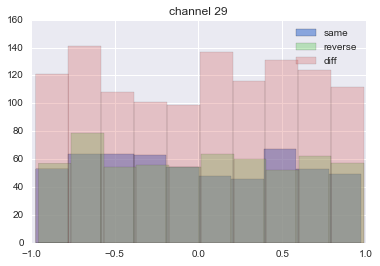

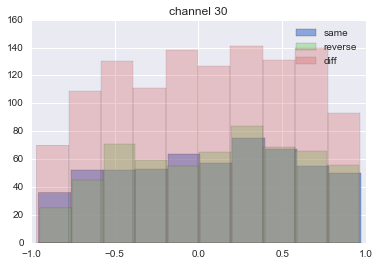

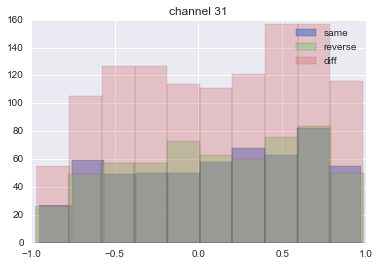

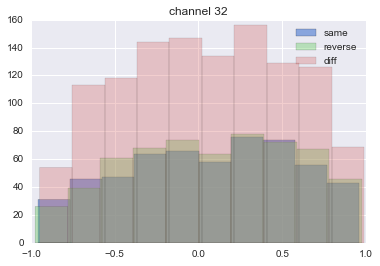

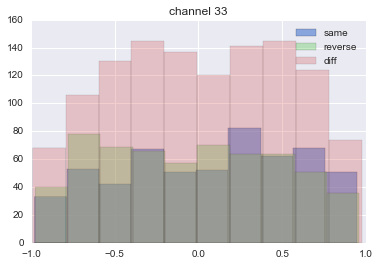

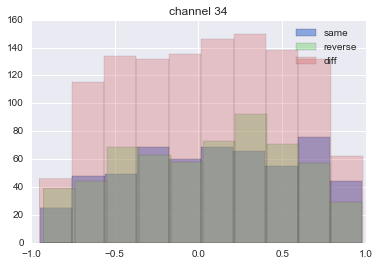

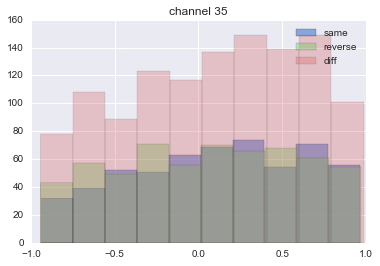

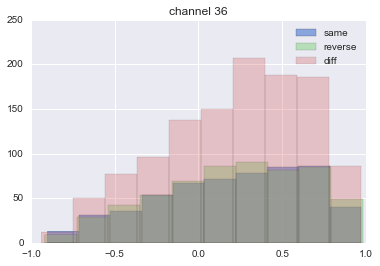

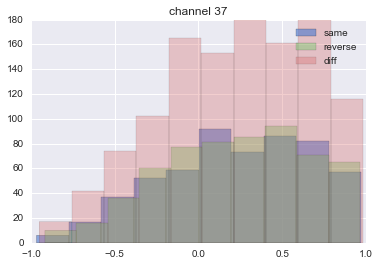

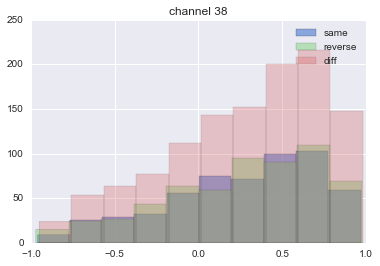

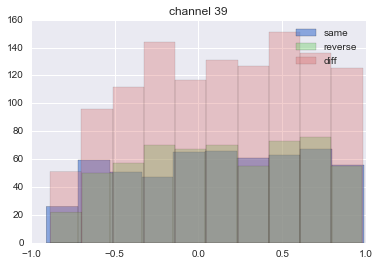

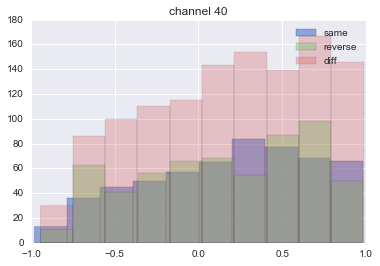

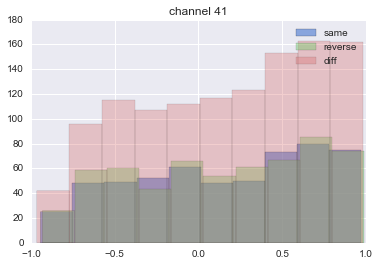

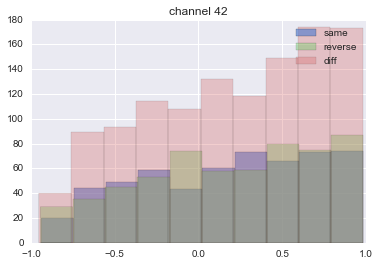

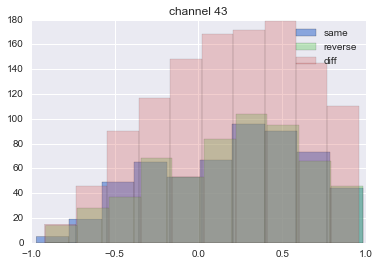

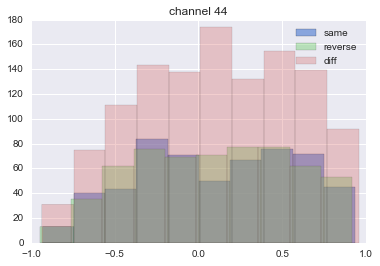

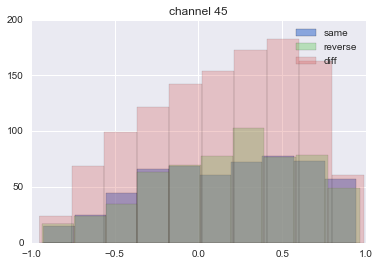

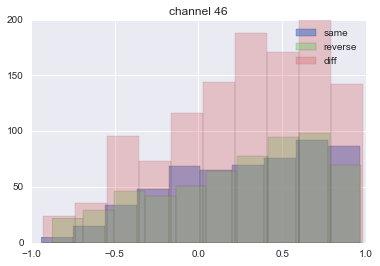

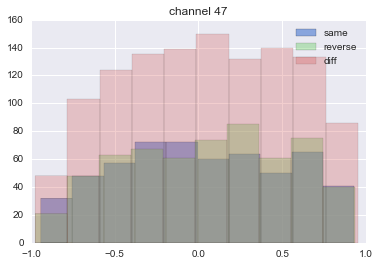

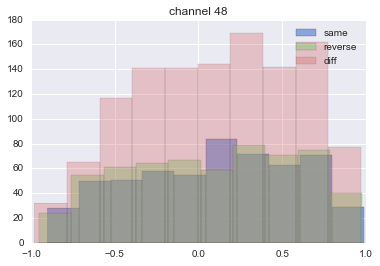

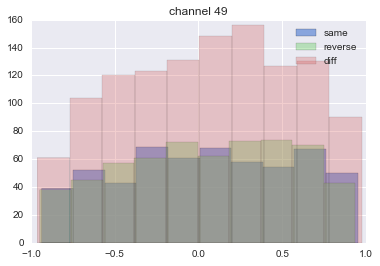

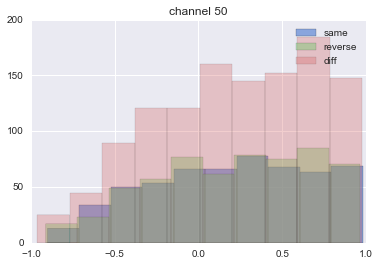

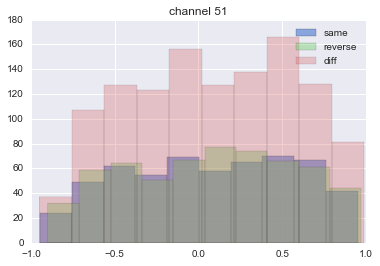

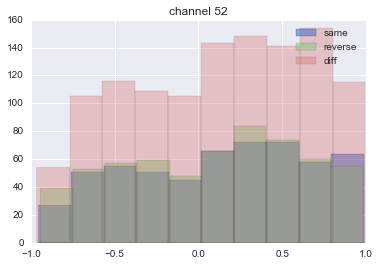

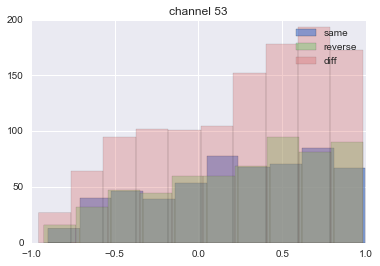

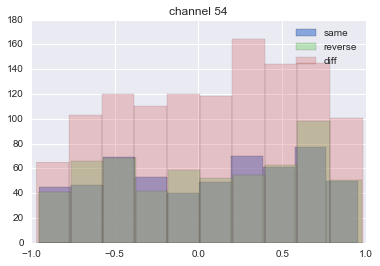

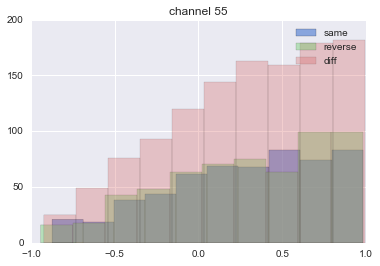

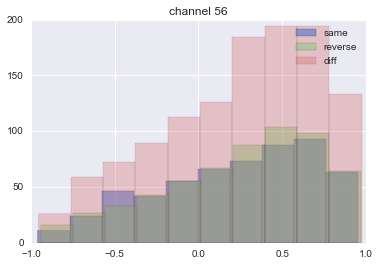

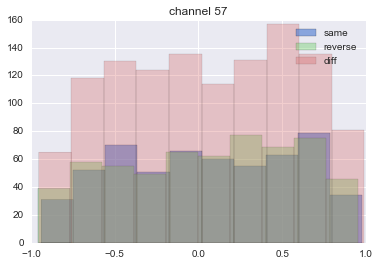

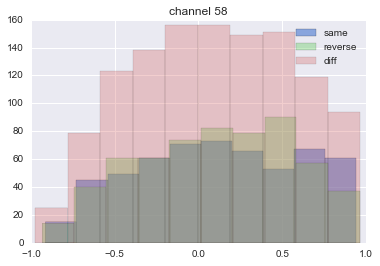

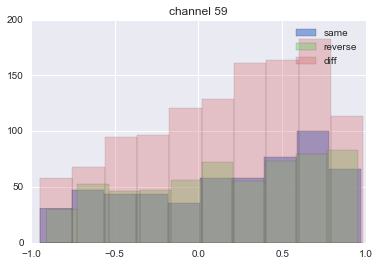

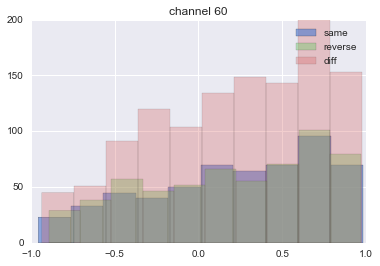

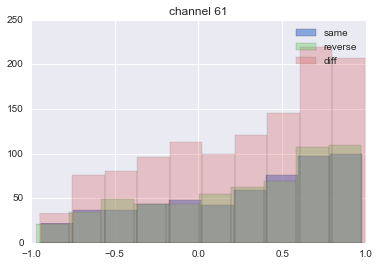

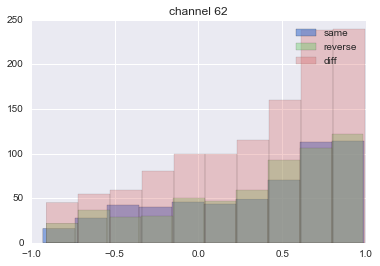

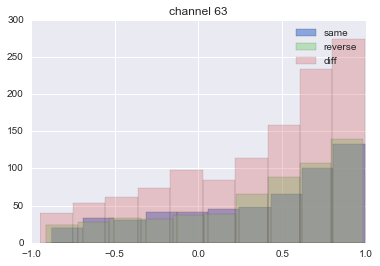

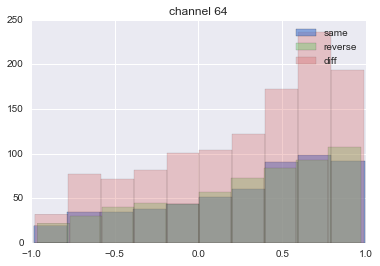

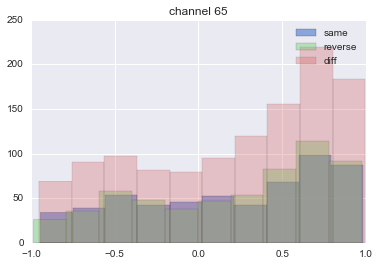

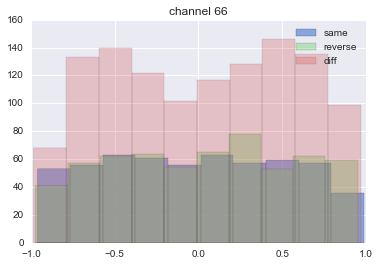

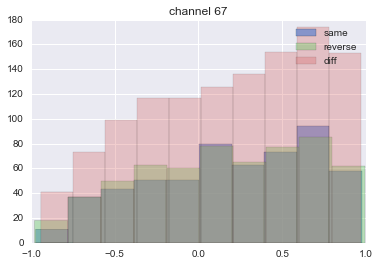

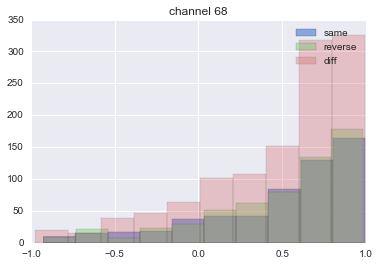

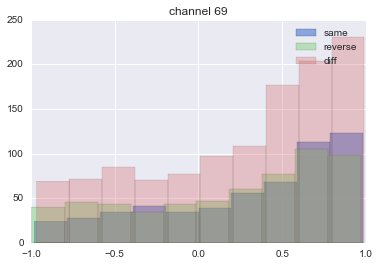

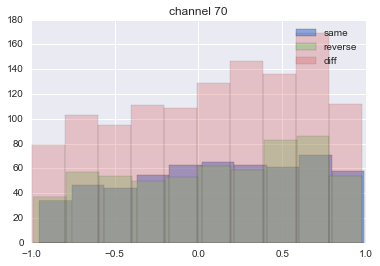

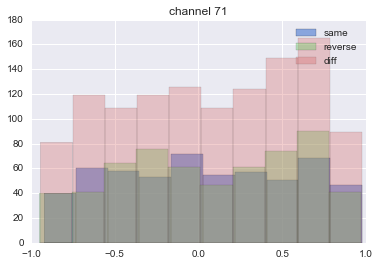

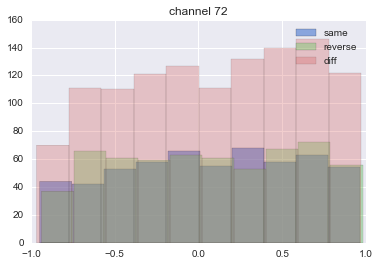

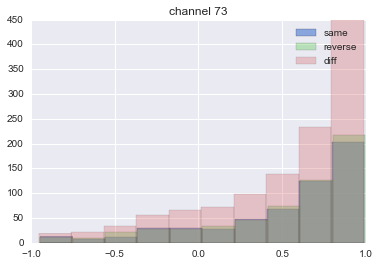

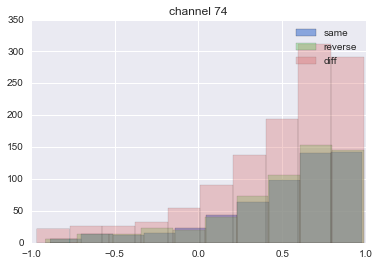

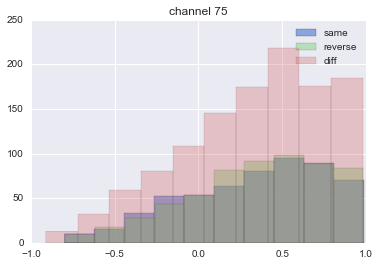

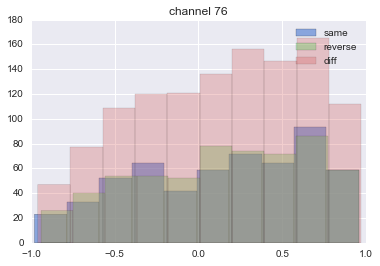

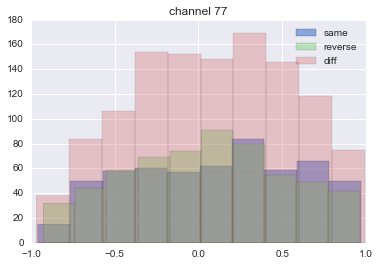

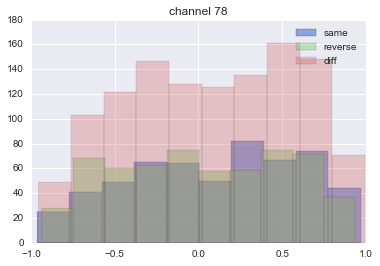

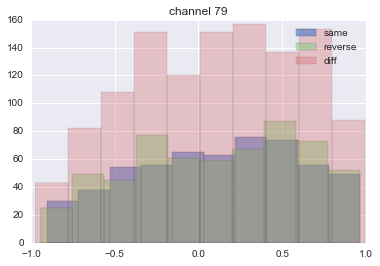

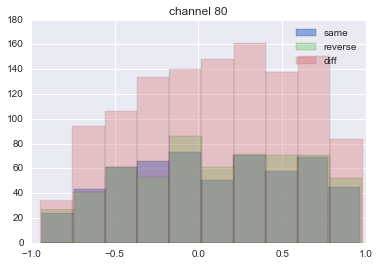

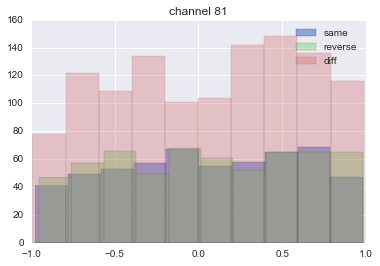

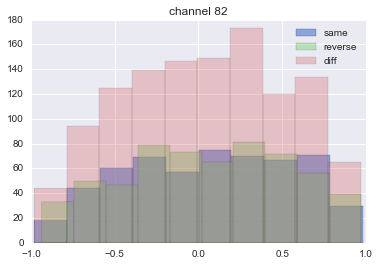

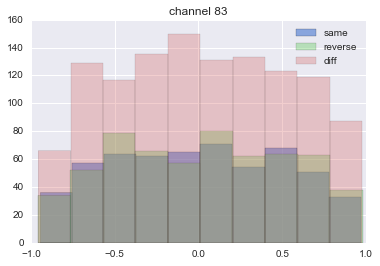

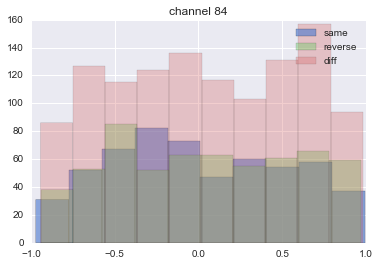

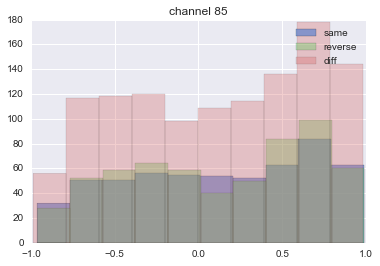

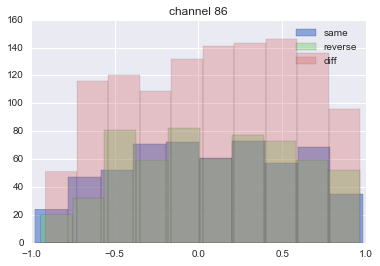

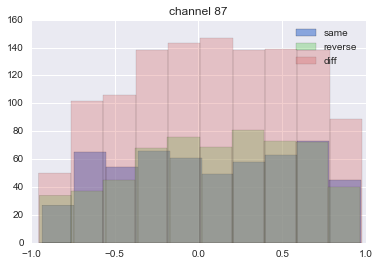

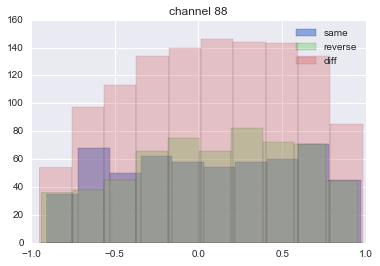

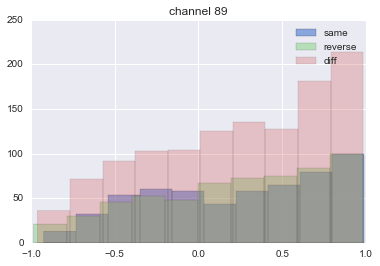

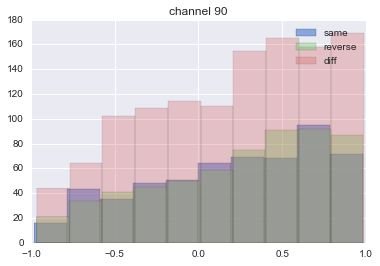

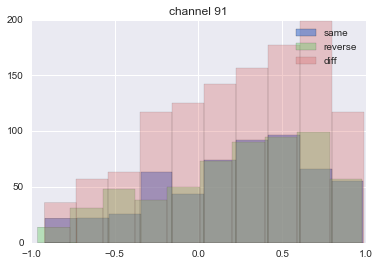

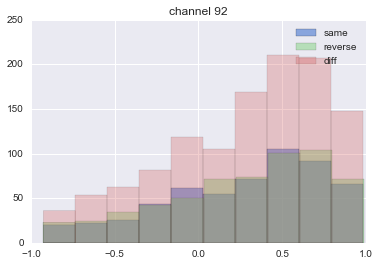

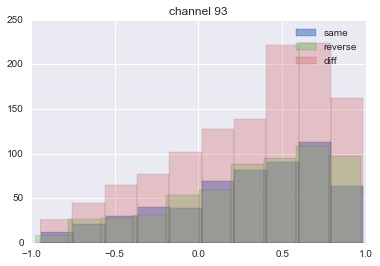

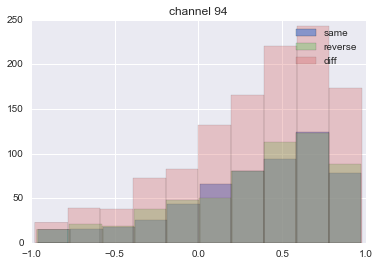

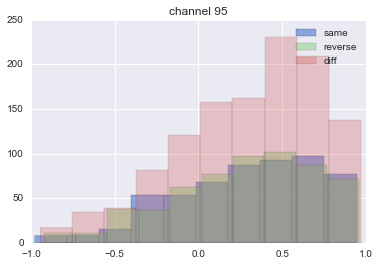

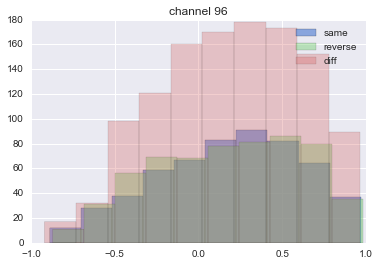

In [83]:
# extract entire data set for this session/block
# block_data = extractSubjSessionBlockData(subj, session, block)
# block data gotten from above cell filtered by response times -> 1-2 seconds

################# 02: Analyze Significant Differences Between Same/Reverse/Different #################
## 01: For each word group, create a word dictionary
## 02: Compute the cosine similarity measures between the word pairs
## 03: Put it into an np array
channels = np.arange(1, 97, 1)
for jdx, chan in enumerate(channels):
    
    same_word_distances, reverse_word_distances, diff_word_distances = getDistances(same_word_group, reverse_word_group, diff_word_group, block_data, chan)
    same_word_distances = flattenArrayDistances(same_word_distances)
    reverse_word_distances = flattenArrayDistances(reverse_word_distances)
    diff_word_distances = flattenArrayDistances(diff_word_distances)
    
    if jdx == 0:
        print same_word_distances.shape
        print reverse_word_distances.shape
        print diff_word_distances.shape
    ## plotting cosine similarity
    fig = plt.figure()
    axes = plt.gca()
    x_range = [-1, 1]
    axes.hist(np.ndarray.flatten(same_word_distances), label='same', alpha=0.6)
    axes.hist(np.ndarray.flatten(reverse_word_distances), label='reverse', alpha=0.4)
    axes.hist(np.ndarray.flatten(diff_word_distances), label='diff', alpha=0.3)
    axes.set_title('channel ' + str(chan))
    plt.legend()

#     break # channel loop

In [78]:
print block_data['meta']
print block_data['data'].keys()
print len([same_word_distances[i] for i in range(0,len(same_word_distances))])
print len(np.ndarray.flatten(same_word_distances))

test = flattenArrayDistances(same_word_distances)
print len(test)

{'session': 'session_1', 'block': 'BLOCK_0', 'subject': 'NIH034'}
['GLASS_JUICE', 'BRICK_CLOCK', 'JUICE_GLASS', 'CLOCK_BRICK']
4
4
136
153
136
136
561


# NIH039 Analysis

In [85]:
######## Load in EVENTS struct to find correct events
eventsDir = '../NIH039/behavioral/paRemap/' + 'events.mat'

events = scipy.io.loadmat(eventsDir)
events = events['events']

# print number of incorrect events and which words they belonged to
incorrectIndices = events['isCorrect'] == 0
incorrectEvents = events[incorrectIndices]
incorrectWords = []
for i in range(0, len(incorrectEvents)):
    incorrectWords.append(incorrectEvents['probeWord'][i][0])


print "There were ",len(incorrectEvents), " number of incorrect events."
print "The list of incorrect probe words: \n", wordList
# 
# get only correct events
correctIndices = events['isCorrect'] == 1
events = events[correctIndices]

print "\nThis is the length of the events struct with only correct responses: ", len(events)

There were  84  number of incorrect events.
The list of incorrect probe words: 
{"[u'PANTS']": 7, "[u'JUICE']": 8, "[u'BRICK']": 12, "[u'CLOCK']": 13, "[u'GLASS']": 9}

This is the length of the events struct with only correct responses:  1396


In [110]:
#### Extract wordpairs data into a dictionary for a subject/session/block
#### dictionary{wordpair:{channels}}
def extractSubjSessionBlockData(subj, session, block):
    # file directory for a subj/session/block
    filedir = '../condensed_data_' + subj + '/sessions/' + session + '/' + block
    wordpairs = os.listdir(filedir) 
    
    # initialize data dictionary with meta data
    data_dict = {}
    data_dict['meta'] = {'subject': subj,
                         'session': session,
                         'block': block}
    data_dict['data'] = {}
    for wordpair in wordpairs:    # loop thru all wordpairs
        wordpair_dir = filedir + '/' + wordpair
        all_channel_mats = os.listdir(wordpair_dir)
        
        data_dict['data'][wordpair] = {}
        for channel in all_channel_mats: # loop thru all channels
            chan_file = wordpair_dir + '/' + channel

            ## 00: load in data
            data = scipy.io.loadmat(chan_file)
            data = data['data']
            
            ## 01: get the time point for probeword on
            timeZero = data['timeZero'][0][0][0]
        
            ## 02: get the time point of vocalization
            vocalization = data['vocalization'][0][0][0]
        
            ## 03: Get Power Matrix
            power_matrix = data['powerMatZ'][0][0]
            
            chan = channel.split('_')[0]
            
            # convert channel data into a json dict
            data_dict['data'][wordpair][chan] = {'timeZero': timeZero,
                                          'timeVocalization':vocalization,
                                          'powerMat': power_matrix}
    
    data_dict['meta']['description'] = data['description'][0][0][0]
    
#     print "The size of power matrices are: ", power_matrix.shape
    
    return data_dict

def isReverse(pair1, pair2):
    pair1split = pair1.split('_')
    pair2split = pair2.split('_')
    if pair1split[0] == pair2split[1] and pair1split[1] == pair2split[0]:
        return True
    else:
        return False
    
# Compute all pairwise distances between first_mat to second_mat
def computePairDistances(first_mat, second_mat):
    distance_list = []
    for idx in range(0, first_mat.shape[0]):
        distance_list.append([distances(x, first_mat[idx,:]) for x in second_mat])
    distance_list = 1.0 - np.ndarray.flatten(np.array(distance_list))
    return distance_list  
    
distances = Distance.euclidean # define distance metric to use
def computeWithinDistances(mat):
    distance_list = np.array(())
    
    distance_list = []
    for idx in range(0, mat.shape[0]):
        for x in mat[idx+1:,:]:
            dist = distances(x,mat[idx,:])
            to_append = np.array(dist)
            distance_list.append(to_append)
            
    distance_list = 1.0 - np.ndarray.flatten(np.array(distance_list))
    return distance_list

In [111]:
def getDistances(same_word_group, reverse_word_group, diff_word_group, block_data, chan):
    ################# 02a: Same Words Cosine Distnace #################
    # extract channel data for same word group
    same_word_dict = {}
    same_word_distances = []
    for same_words in same_word_group:
        same_word_data = [] # array to store all the feature freq. vectors for a specific word

        # extract data to process - average across time 
        same_word_key = same_words[0]
        probeOnTime = block_data['data'][same_word_key][str(chan)]['timeZero']
        vocalizationTime = block_data['data'][same_word_key][str(chan)]['timeVocalization']
        powerMat = block_data['data'][same_word_key][str(chan)]['powerMat']

        for i in range(0, len(vocalizationTime)):
            # either go from timezero -> vocalization, or some other timewindow
            same_word_data.append(np.ndarray.flatten(np.mean(powerMat[i,:,probeOnTime:vocalizationTime[i]],axis=1)))
        same_word_data = np.array(same_word_data)
        # do a pairwise comparison of all events in this word pair
        same_word_data = computeWithinDistances(same_word_data)
        same_word_dict[same_word_key] = same_word_data

    for key in same_word_dict.keys():
        same_word_distances.append(same_word_dict[key])
    same_word_distances = np.array(same_word_distances)

    ################# 02b: Reverse Words Cosine Distnace #################
    # extract channel data for same word group
    reverse_word_dict = {}
    reverse_word_distances = []
    for reverse_words in reverse_word_group:
        reverse_word_data = {}

        for wdx, word in enumerate(reverse_words): # get the first and second word pair
            reverse_word_databuffer = []

            # extract wordKey and data from MAIN block dictinoary
            reverse_word_key = reverse_words[wdx]
            probeOnTime = block_data['data'][reverse_word_key][str(chan)]['timeZero']
            vocalizationTime = block_data['data'][reverse_word_key][str(chan)]['timeVocalization']
            powerMat = block_data['data'][reverse_word_key][str(chan)]['powerMat']

            # average across time and append a frequency feature vector for every event in this group
            for i in range(0, len(vocalizationTime)):
                # either go from timezero -> vocalization, or some other timewindow
                reverse_word_databuffer.append(np.ndarray.flatten(np.mean(powerMat[i,:,probeOnTime:vocalizationTime[i]],axis=1)))
            reverse_word_data[str(wdx)] = np.array(reverse_word_databuffer)

        # do a pairwise comparison of all events in this word pair
        reverse_word_dict['vs'.join(reverse_words)] = computePairDistances(reverse_word_data['0'], reverse_word_data['1'])

    for key in reverse_word_dict.keys():
        reverse_word_distances.append(reverse_word_dict[key])
    reverse_word_distances = np.array(reverse_word_distances)

    ################# 02c: Different Words Cosine Distnace #################
    # extract channel data for same word group
    diff_word_dict = {}
    diff_word_distances = []
    for diff_words in diff_word_group:
        diff_word_data = {}

        # extract data to process - average across time 
        for wdx, word in enumerate(diff_words): # get the first and second word pair
            diff_word_databuffer = []

            # extract wordKey and data from MAIN block dictinoary
            diff_word_key = diff_words[wdx]
            probeOnTime = block_data['data'][diff_word_key][str(chan)]['timeZero']
            vocalizationTime = block_data['data'][diff_word_key][str(chan)]['timeVocalization']
            powerMat = block_data['data'][diff_word_key][str(chan)]['powerMat']

            # average across time and append a frequency feature vector for every event in this group
            for i in range(0, len(vocalizationTime)):
                # either go from timezero -> vocalization, or some other timewindow
                diff_word_databuffer.append(np.ndarray.flatten(np.mean(powerMat[i,:,probeOnTime:vocalizationTime[i]],axis=1)))
            diff_word_data[str(wdx)] = np.array(diff_word_databuffer)

        # do a pairwise comparison of all events in this word pair
        diff_word_dict['vs'.join(diff_words)] = computePairDistances(diff_word_data['0'], diff_word_data['1'])
    # put all word distances into 1 list
    for key in diff_word_dict.keys():
        diff_word_distances.append(diff_word_dict[key])
    diff_word_distances = np.array(diff_word_distances)
    
#     print same_word_dict.keys()
#     print reverse_word_dict.keys()
#     print diff_word_dict.keys()
    
    return same_word_distances, reverse_word_distances, diff_word_distances

def flattenArrayDistances(word_distances):
    buff_distances = np.array(())
    for i in range(0, len(word_distances)):
        buff_distances = np.append(buff_distances, word_distances[i], axis=0)
    return buff_distances

In [112]:
######## Get list of files (.mat) we want to work with ########
subj = 'NIH039'
filedir = '../condensed_data_NIH039/sessions/'
sessions = os.listdir(filedir)
# sessions = sessions[2:]

# loop through each session
for session in sessions:
    print "Analyzing session ", session, " WITHIN BLOCKS."
    sessiondir = filedir + session
    
    # get all blocks for this session
    blocks = os.listdir(sessiondir)
    
    if len(blocks) != 6: # error check on the directories
        print blocks
        print("Error in the # of blocks. There should be 5.")
        break
    
    # loop through each block one at a time, analyze
    for i in range(0, 6):
        print "Analyzing block ", blocks[i]
        block = blocks[i]
        block_dir = sessiondir + '/' + block

        # 
        print 'Subject: ', subj
        print 'Session: ', session
        print 'Block: ', block
        
        block_data = extractSubjSessionBlockData(subj, session, block)
        print block_data['data'].keys()
        
        # in each block, get list of word pairs from first and second block
        wordpairs = os.listdir(block_dir)
       
        # within-groups analysis only has: SAME, REVERSE, DIFFERENT
        diff_word_group = []
        reverse_word_group = []
        same_word_group = []
        
        print "These are the wordpairs in this block: ", wordpairs
        
        ################# 01: Create WordPair Groups #################
        # create same group pairs
        for idx, pair in enumerate(wordpairs):
            same_word_group.append([pair, pair])
        
        # create reverse, and different groups
        for idx, pairs in enumerate(itertools.combinations(wordpairs,2)):
            if isReverse(pairs[0], pairs[1]):
                reverse_word_group.append([pairs[0], pairs[1]])
            else:
                diff_word_group.append([pairs[0], pairs[1]])
        
        break
    print "\nGot same_word_group, reverse_word_group and diff_word_group for session: ", session
    print "\n",same_word_group
    print "\n",reverse_word_group
    print "\n",diff_word_group
    break

Analyzing session  session_0  WITHIN BLOCKS.
Analyzing block  BLOCK_0
Subject:  NIH039
Session:  session_0
Block:  BLOCK_0
['GLASS_JUICE', 'BRICK_CLOCK', 'JUICE_GLASS', 'CLOCK_BRICK']
These are the wordpairs in this block:  ['BRICK_CLOCK', 'CLOCK_BRICK', 'GLASS_JUICE', 'JUICE_GLASS']

Got same_word_group, reverse_word_group and diff_word_group for session:  session_0

[['BRICK_CLOCK', 'BRICK_CLOCK'], ['CLOCK_BRICK', 'CLOCK_BRICK'], ['GLASS_JUICE', 'GLASS_JUICE'], ['JUICE_GLASS', 'JUICE_GLASS']]

[['BRICK_CLOCK', 'CLOCK_BRICK'], ['GLASS_JUICE', 'JUICE_GLASS']]

[['BRICK_CLOCK', 'GLASS_JUICE'], ['BRICK_CLOCK', 'JUICE_GLASS'], ['CLOCK_BRICK', 'GLASS_JUICE'], ['CLOCK_BRICK', 'JUICE_GLASS']]


In [113]:
print "Meta data: ", block_data['meta'] # print meta data for this dict

### FOR CERTAIN SESSION BLOCK
# loop through each wordpair
bufferblock_data = block_data
wordpairs = block_data['data'].keys()
print "Data available per channel: ", block_data['data'][wordpairs[0]]['1'].keys()

for wordpair in wordpairs:
    wordpairdata = block_data['data'][wordpair]
    for chan in wordpairdata.keys():
        timeVocalization = wordpairdata[chan]['timeVocalization']
        timeZero = wordpairdata[chan]['timeZero']
        powerMat = wordpairdata[chan]['powerMat']
        
        onesec_indices = np.where(timeVocalization <= 40)
        onetwosec_indices = np.where((timeVocalization <= 60) & (timeVocalization > 40))[0]
        twothreesec_indices = np.where((timeVocalization <= 80) & (timeVocalization > 60))[0]

        # reformat data to get the indices we want 
        block_data['data'][wordpair][chan]['timeVocalization'] = timeVocalization[onetwosec_indices]
        block_data['data'][wordpair][chan]['powerMat'] = powerMat[onetwosec_indices,:,:] 
        
print timeZero

Meta data:  {'session': 'session_0', 'description': u'100 ms windows, 50 ms overlap. With eeg data from -1 to 5 seconds after probeWordOn.', 'block': 'BLOCK_0', 'subject': 'NIH039'}
Data available per channel:  ['powerMat', 'timeZero', 'timeVocalization']
[20]


(132,)
(144,)
(285,)


/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/adam2392/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:76: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


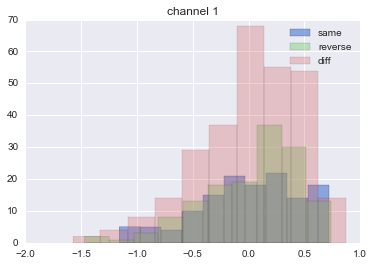

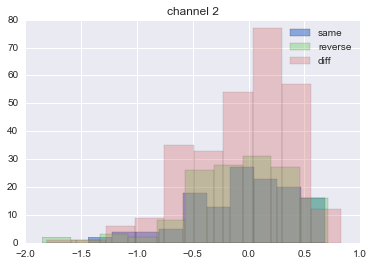

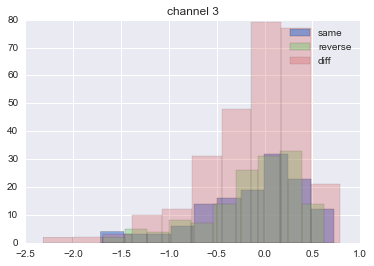

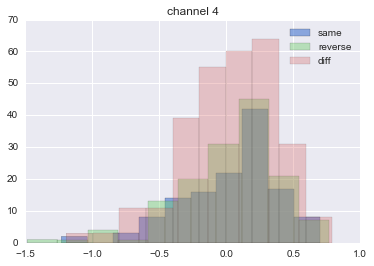

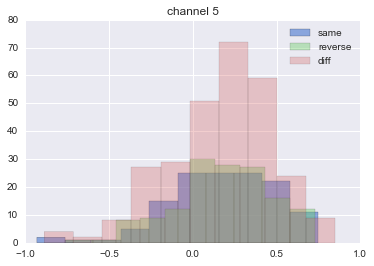

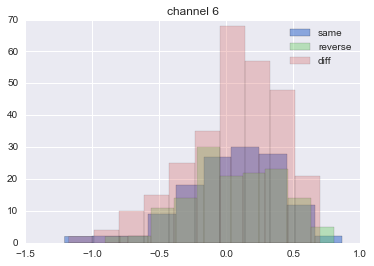

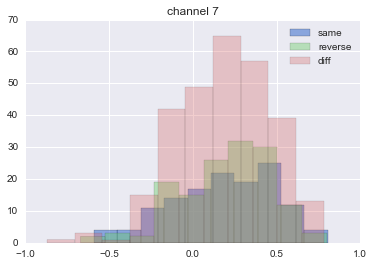

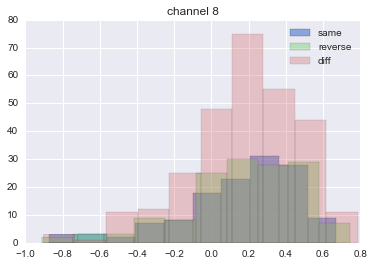

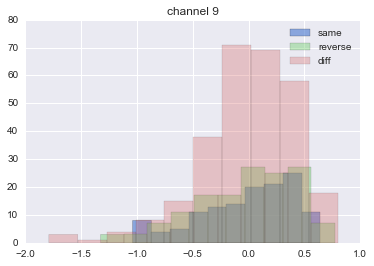

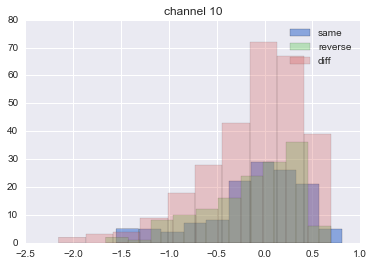

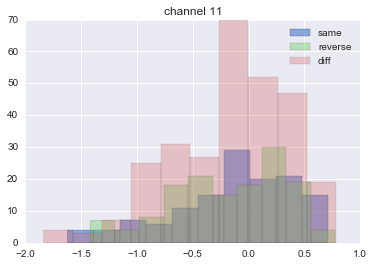

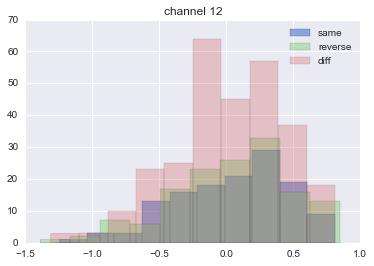

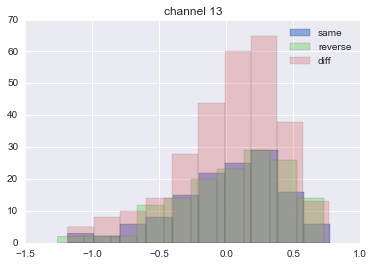

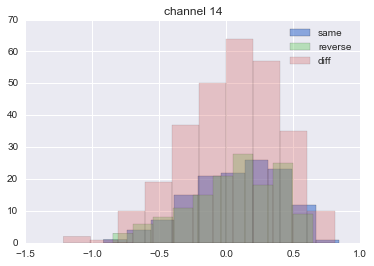

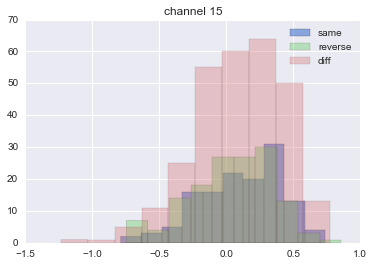

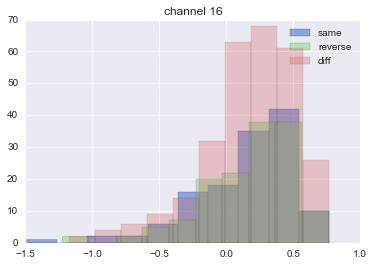

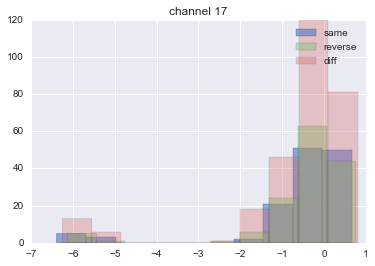

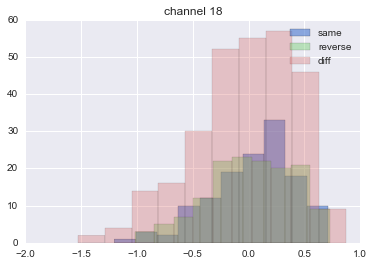

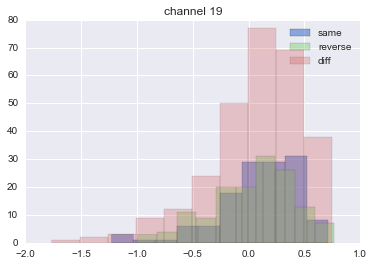

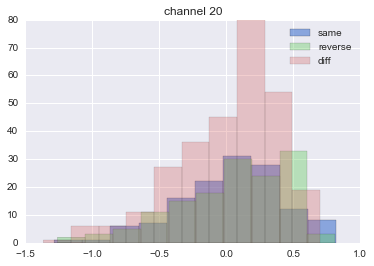

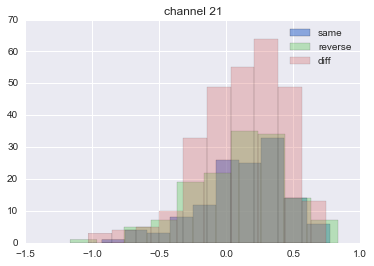

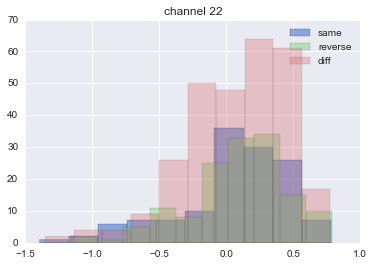

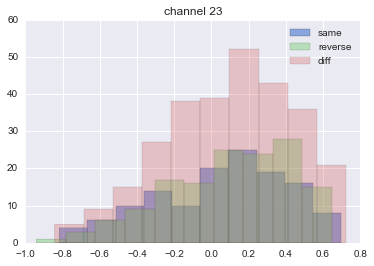

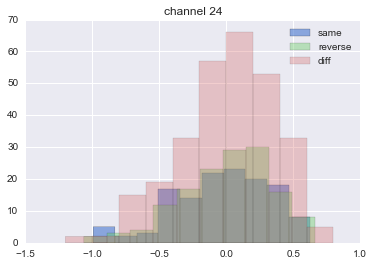

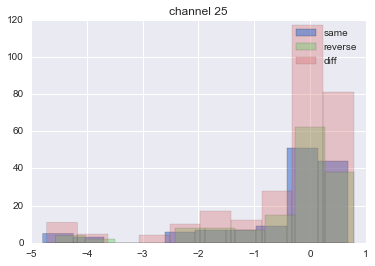

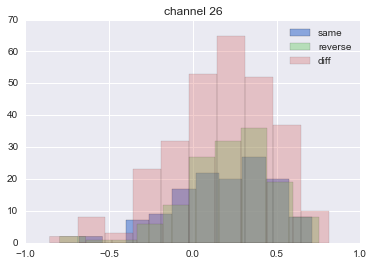

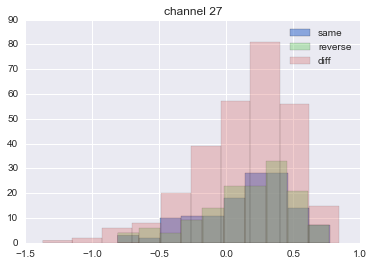

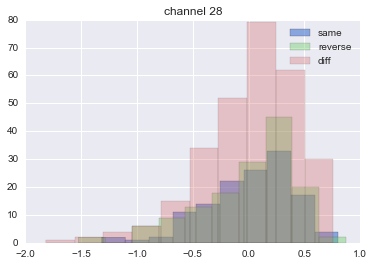

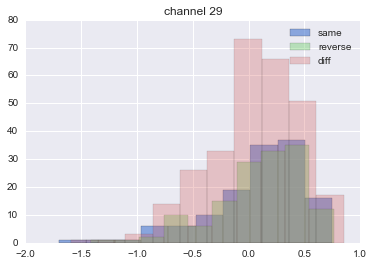

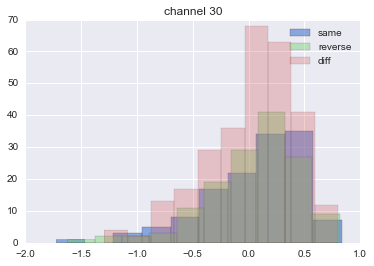

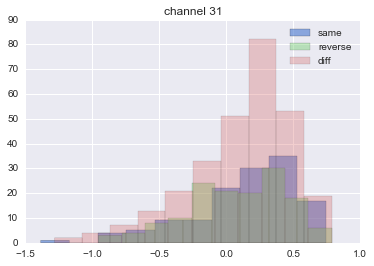

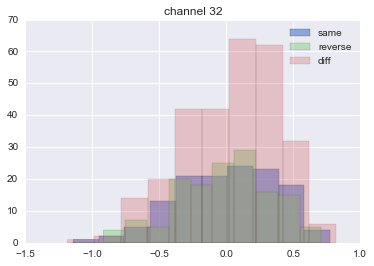

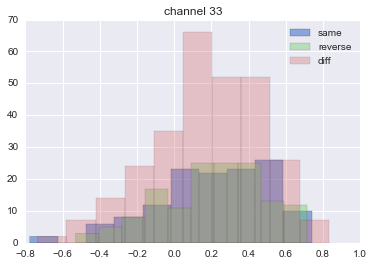

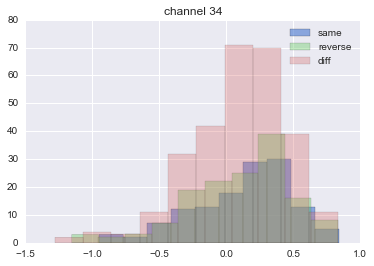

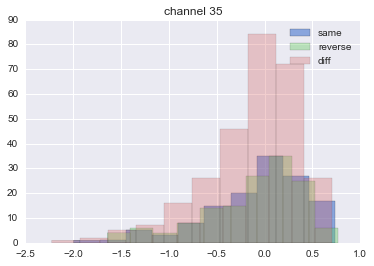

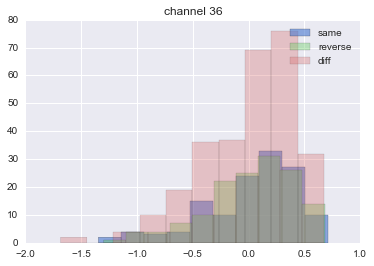

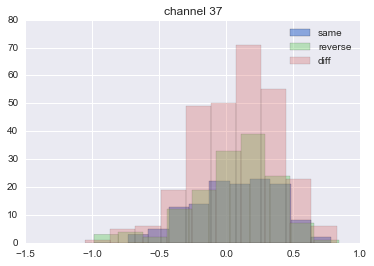

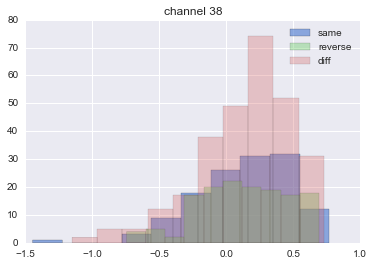

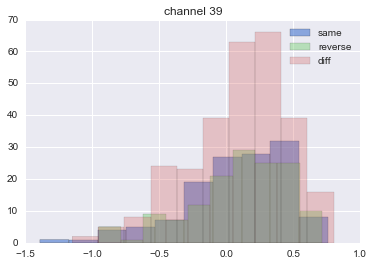

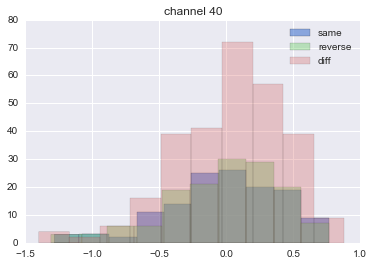

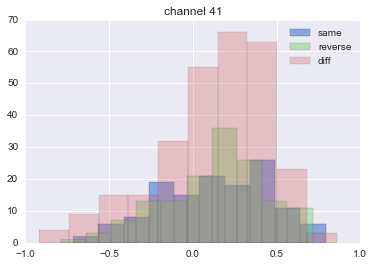

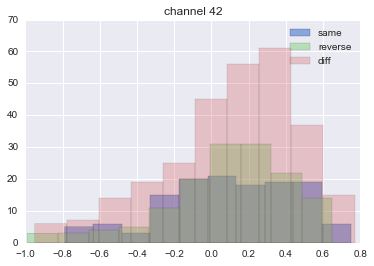

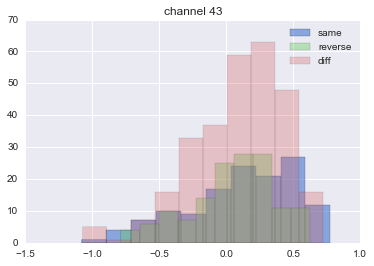

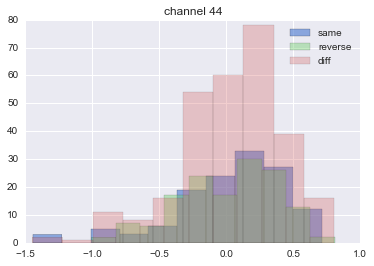

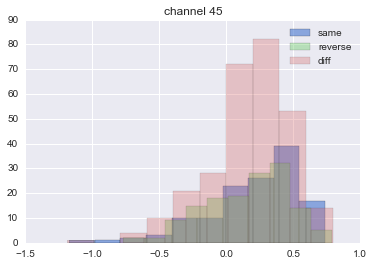

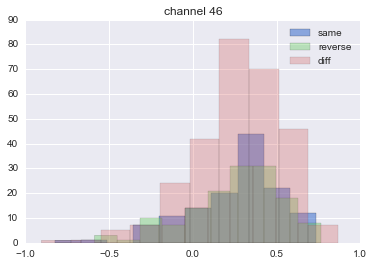

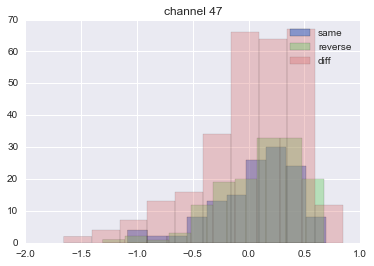

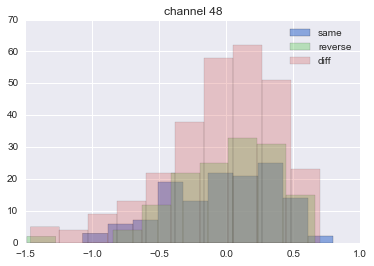

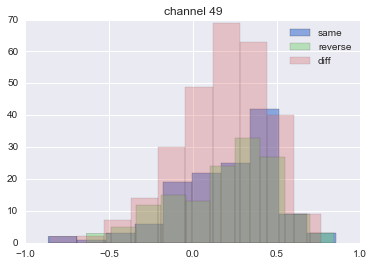

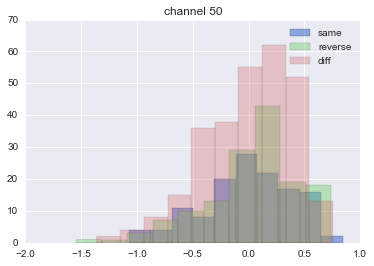

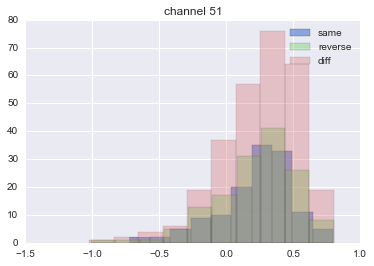

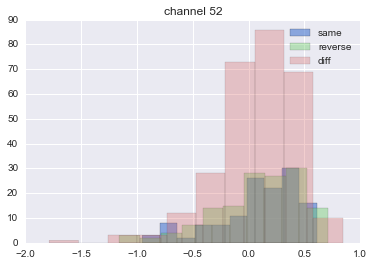

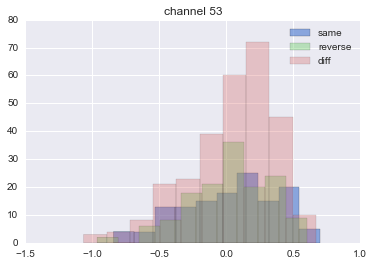

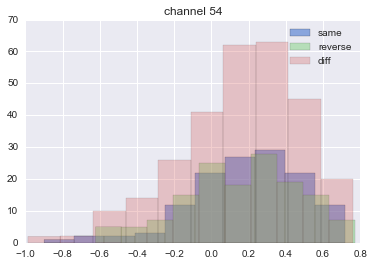

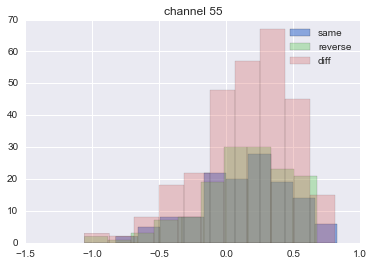

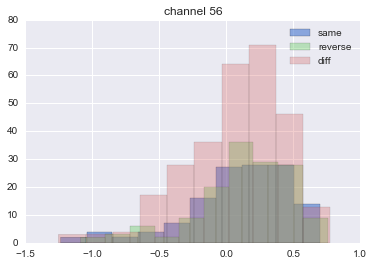

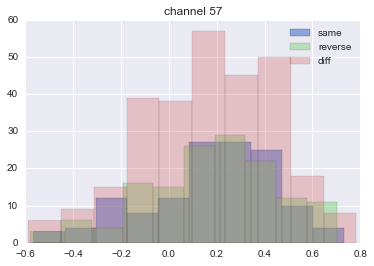

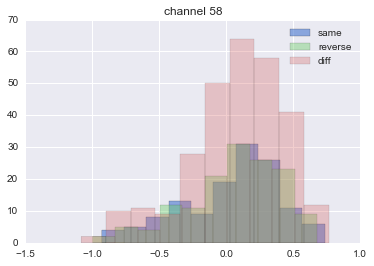

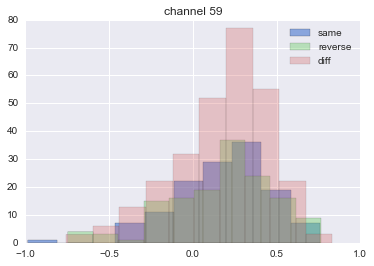

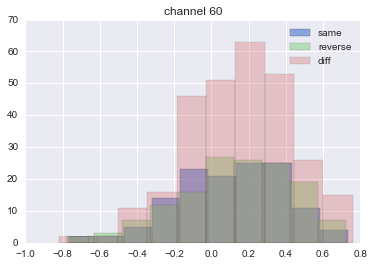

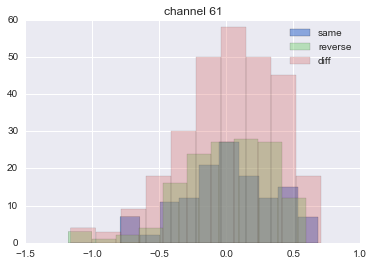

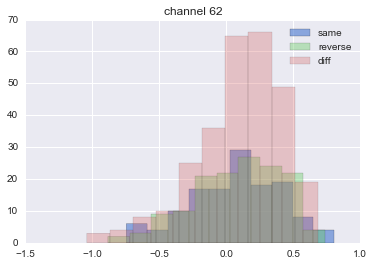

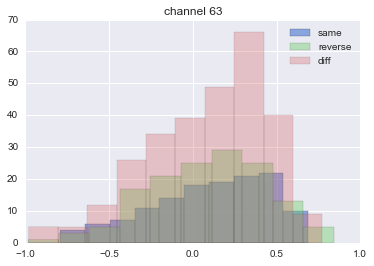

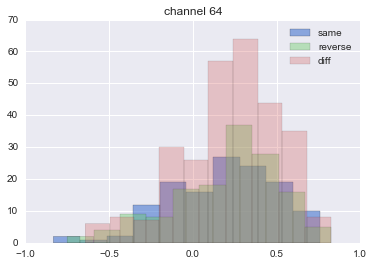

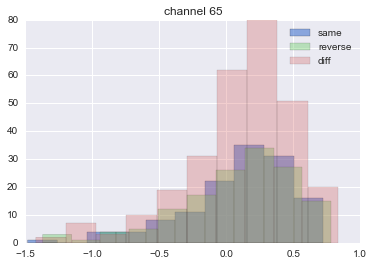

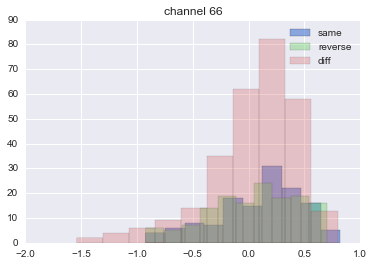

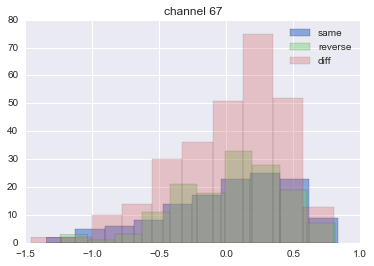

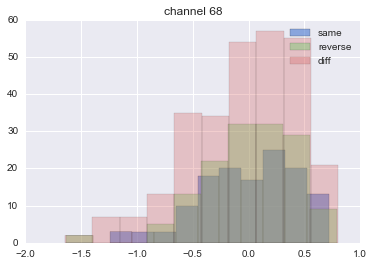

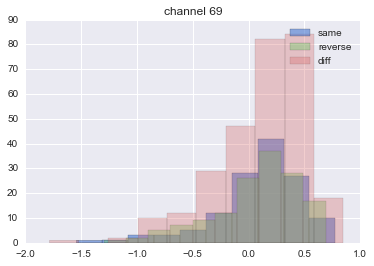

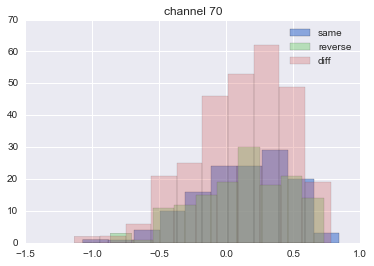

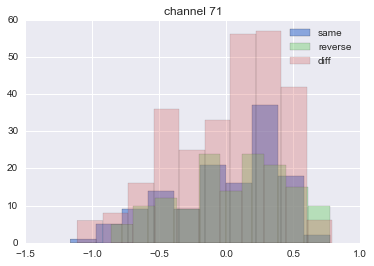

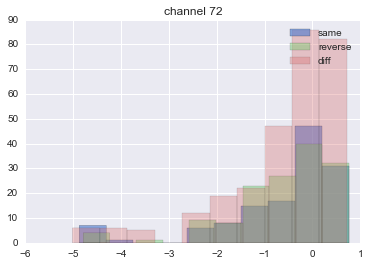

In [114]:
################# 02: Analyze Significant Differences Between Same/Reverse/Different #################
## 01: For each word group, create a word dictionary
## 02: Compute the cosine similarity measures between the word pairs
## 03: Put it into an np array
channels = np.arange(1, 73, 1)
for jdx, chan in enumerate(channels):
    
    same_word_distances, reverse_word_distances, diff_word_distances = getDistances(same_word_group, reverse_word_group, diff_word_group, block_data, chan)
    same_word_distances = flattenArrayDistances(same_word_distances)
    reverse_word_distances = flattenArrayDistances(reverse_word_distances)
    diff_word_distances = flattenArrayDistances(diff_word_distances)
    
    if jdx == 0:
        print same_word_distances.shape
        print reverse_word_distances.shape
        print diff_word_distances.shape
    ## plotting cosine similarity
    fig = plt.figure()
    axes = plt.gca()
    x_range = [-1, 1]
    axes.hist(np.ndarray.flatten(same_word_distances), label='same', alpha=0.6)
    axes.hist(np.ndarray.flatten(reverse_word_distances), label='reverse', alpha=0.4)
    axes.hist(np.ndarray.flatten(diff_word_distances), label='diff', alpha=0.3)
    axes.set_title('channel ' + str(chan))
    plt.legend()
    
#     break